# How to call tools using ToolNode

This guide covers how to use LangGraph's prebuilt [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) for tool calling.

`ToolNode` is a LangChain Runnable that takes graph state (with a list of messages) as input and outputs state update with the result of tool calls. It is designed to work well out-of-box with LangGraph's prebuilt [ReAct agent](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/), but can also work with any `StateGraph` as long as its state has a `messages` key with an appropriate reducer (see [`MessagesState`](https://github.com/langchain-ai/langgraph/blob/e3ef9adac7395e5c0943c22bbc8a4a856b103aa3/libs/langgraph/langgraph/graph/message.py#L150)).

## Setup

First, let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Define tools

In [2]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

In [3]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."


@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "nyc, sf"

In [4]:
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

## Manually call `ToolNode`

`ToolNode` operates on graph state with a list of messages. It expects the last message in the list to be an `AIMessage` with `tool_calls` parameter. 

Let's first see how to invoke the tool node manually:

In [6]:
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id')]}

Note that typically you don't need to create `AIMessage` manually, and it will be automatically generated by any LangChain chat model that supports tool calling.

You can also do parallel tool calling using `ToolNode` if you pass multiple tool calls to `AIMessage`'s `tool_calls` parameter:

In [7]:
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_coolest_cities",
            "args": {},
            "id": "tool_call_id_1",
            "type": "tool_call",
        },
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
    ],
)

tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='nyc, sf', name='get_coolest_cities', tool_call_id='tool_call_id_1'),
  ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id_2')]}

## Using with chat models

We'll be using a small chat model from Anthropic in our example. To use chat models with tool calling, we need to first ensure that the model is aware of the available tools. We do this by calling `.bind_tools` method on `ChatAnthropic` moodel

In [5]:
from typing import Literal

from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


model_with_tools = ChatAnthropic(
    model="claude-3-haiku-20240307", temperature=0
).bind_tools(tools)

In [9]:
model_with_tools.invoke("what's the weather in sf?").tool_calls

[{'name': 'get_weather',
  'args': {'location': 'San Francisco'},
  'id': 'toolu_01Fwm7dg1mcJU43Fkx2pqgm8',
  'type': 'tool_call'}]

As you can see, the AI message generated by the chat model already has `tool_calls` populated, so we can just pass it directly to `ToolNode`

In [10]:
tool_node.invoke({"messages": [model_with_tools.invoke("what's the weather in sf?")]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='toolu_01LFvAVT3xJMeZS6kbWwBGZK')]}

## ReAct Agent

Next, let's see how to use `ToolNode` inside a LangGraph graph. Let's set up a graph implementation of the [ReAct agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent). This agent takes some query as input, then repeatedly call tools until it has enough information to resolve the query. We'll be using `ToolNode` and the Anthropic model with tools we just defined

In [6]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

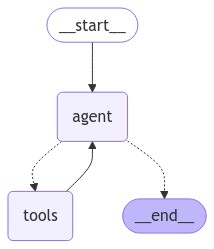

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's try it out!

In [13]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "what's the weather in sf?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in sf?
================================== Ai Message ==================================

[{'text': "Okay, let's check the weather in San Francisco:", 'type': 'text'}, {'id': 'toolu_01LdmBXYeccWKdPrhZSwFCDX', 'input': {'location': 'San Francisco'}, 'name': 'get_weather', 'type': 'tool_use'}]
Tool Calls:
  get_weather (toolu_01LdmBXYeccWKdPrhZSwFCDX)
 Call ID: toolu_01LdmBXYeccWKdPrhZSwFCDX
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

The weather in San Francisco is currently 60 degrees with foggy conditions.


In [14]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "what's the weather in the coolest cities?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in the coolest cities?
================================== Ai Message ==================================

[{'text': "Okay, let's find out the weather in the coolest cities:", 'type': 'text'}, {'id': 'toolu_01LFZUWTccyveBdaSAisMi95', 'input': {}, 'name': 'get_coolest_cities', 'type': 'tool_use'}]
Tool Calls:
  get_coolest_cities (toolu_01LFZUWTccyveBdaSAisMi95)
 Call ID: toolu_01LFZUWTccyveBdaSAisMi95
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

nyc, sf
================================== Ai Message ==================================

[{'text': "Now let's get the weather for those cities:", 'type': 'text'}, {'id': 'toolu_01RHPQBhT1u6eDnPqqkGUpsV', 'input': {'location': 'nyc'}, 'name': 'get_weather', 'type': 'tool_use'}]
Tool Calls:
  get_weather (toolu_01RHPQBhT1u6eDnPqqkGUpsV)
 Call ID: toolu_01RHPQBhT1u6eDnPqqkGUpsV
  

`ToolNode` can also handle errors during tool execution. You can enable / disable this by setting `handle_tool_errors=True` (enabled by default). See our guide on handling errors in `ToolNode` [here](https://langchain-ai.github.io/langgraph/how-tos/tool-calling-errors/)